In [25]:
import os
# from dotenv.main import load_dotenv
from dotenv import load_dotenv
from pydantic import BaseModel
from typing import Literal

In [26]:
import together
import chromadb
from langsmith.wrappers import wrap_openai
from langsmith import traceable

from tavily import TavilyClient
from typing_extensions import TypedDict
from openai import OpenAI
from together import Together
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from langgraph.graph import END, StateGraph, START, MessagesState

In [27]:
load_dotenv()

True

In [28]:
LANGCHAIN_TRACING_V2 = True
LANGCHAIN_ENDPOINT = "https://api.smith.langchain.com"
LANGCHAIN_PROJECT = "my_test_project"

In [29]:
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

In [30]:
EMBEDDING_MODEL = "text-embedding-3-small"
CURR_LLM_MODEL = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"

In [31]:
together_client = wrap_openai(Together(api_key=TOGETHER_API_KEY))
together_client

In [32]:
@traceable
def llm_pipeline(user_input: str) -> str:
    result = together_client.chat.completions.create(
        messages=[{"role": "user", "content": user_input}], model=CURR_LLM_MODEL
    )
    return result.choices[0].message.content

In [33]:
llm_pipeline("Hi there. What model are you?")

'I\'m an AI model known as Llama. Llama stands for "Large Language Model Meta AI."'

## CHROMA DB SET UP


In [34]:
embedding_function = OpenAIEmbeddingFunction(
    api_key=OPENAI_API_KEY, model_name=EMBEDDING_MODEL
)
chroma_client = chromadb.Client()

In [36]:
# collection = chroma_client.create_collection(
#     name="marcus_collection", embedding_function=embedding_function
# )

collection = chroma_client.get_collection(
    name="marcus_collection", embedding_function=embedding_function
)

In [37]:
with open("marcus_quotes.txt", "r") as reader:
    marcus_list = reader.readlines()[:150]
ids_list = [f"id{i+1}" for i in range(len(marcus_list))]

In [40]:
collection.add(documents=marcus_list, ids=ids_list)

In [41]:
collection.query(
    query_texts=["I want to learn good morals and the government of my temper"],
    n_results=2,
)

{'ids': [['id1', 'id15']],
 'embeddings': None,
 'documents': [['From my grandfather Verus I learned good morals and the government of my temper.\n',
   'From Maximus I learned self-government, and not to be led aside by anything; and cheerfulness in all circumstances, as well as in illness; and a just admixture in the moral character of sweetness and dignity, and to do what was set before me without complaining. I observed that everybody believed that he thought as he spoke, and that in all that he did he never had any bad intention; and he never showed amazement and surprise, and was never in a hurry, and never put off doing a thing, nor was perplexed nor dejected, nor did he ever laugh to disguise his vexation, nor, on the other hand, was he ever passionate or suspicious. He was accustomed to do acts of beneficence, and was ready to forgive, and was free from all falsehood; and he presented the appearance of a man who could not be diverted from right rather than of a man who had bee

In [42]:
collection.query(
    query_texts=[
        "Я хочу научиться хорошим моральным принципам и управлению моим темпераментом"
    ],
    n_results=1,
)["documents"]

[['From my grandfather Verus I learned good morals and the government of my temper.\n']]

In [43]:
collection.query(
    query_texts=[
        "Я хочу научиться хорошим моральным принципам и управлению моим темпераментом"
    ],
    n_results=1,
)

{'ids': [['id1']],
 'embeddings': None,
 'documents': [['From my grandfather Verus I learned good morals and the government of my temper.\n']],
 'uris': None,
 'data': None,
 'metadatas': [[None]],
 'distances': [[1.2780762910842896]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## TavilyClient setup


In [47]:
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

In [48]:
tavily_client.search("Who is Aomine Daiki?")

{'query': 'Who is Aomine Daiki?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Aomine Daiki: The Phenomenal Basketball Star of Kuroko's Basketball",
   'url': 'https://dailyflares.com/aomine-daiki/',
   'content': "Aomine Daiki is a standout character in the popular anime and manga series Kuroko's Basketball. Known for his exceptional basketball skills and charismatic personality, Aomine has captured the hearts of fans worldwide. This article delves into the life and career of Aomine Daiki, exploring his role in Kuroko's Basketball, his basketball",
   'score': 0.9998233,
   'raw_content': None},
  {'title': 'Daiki Aomine - Kuroko no Basuke Wiki',
   'url': 'https://kurokonobasuke.fandom.com/wiki/Daiki_Aomine',
   'content': "Daiki Aomine (青峰 大輝 Aomine Daiki) was the ace player of the renowned Generation of Miracles and was the former partner/light of Tetsuya Kuroko in Teikō Junior High. After hearing a benched teammate insult Tetsuya Kuroko and

In [49]:
tavily_client.search("Кто такой Борис Рыжий?", max_results=2)

{'query': 'Кто такой Борис Рыжий?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'История легендарного поэта Бориса Рыжего, который прожил всего 26 лет ...',
   'url': 'https://ngs.ru/text/culture/2024/09/09/74062475/',
   'content': 'История поэта Бориса Рыжего, который ушел из жизни в 26 лет и прославился на весь мир История поэта Бориса Рыжего, который ушел из жизни в 26 лет и прославился на весь мир По его словам, Борис Рыжий «был и жил целиком в поэзии, а это\xa0— смертельно». В 1991 году Рыжий пошел по стопам отца и поступил в Свердловский горный институт (на самом деле\xa0— потому что больше было некуда). Писатель Евгений Касимов рассказал E1.RU, что был не так близко знаком с Борисом: несколько раз они работали вместе, делали передачи на радио и ходили друг к другу в гости. Хамство, невежество и мракобесие: врач-педиатр — о том, что его бесит в пациентах Хамство, невежество и мракобесие: врач-педиатр — о том, что его бесит в пациентах',
 

## Prompts for simple function calls


In [55]:
router_prompt = """
    SYSTEM:
    You are an expert at routing a user question to a vectorstore or web search. 
    Vectorstore is consists of the quotes of Marcus Aurelius. If there is an emotion or need for
    an advicce for life situation or just a complain or an advice, 
    use the vectorstore. For all other questions use web-search
    Give a binary choice 'web_search' or 'vectorstore' based on the question. Return a string with a single word 'web_search' or 'vectorstore' and 
    no premable or explaination. 

    Example:
        Question: I want to learn good morals and the government of my temper.
        Answer: 'vectorstore'

    USER:
    """

In [67]:
stoic_prompt = """
    SYSTEM:
    You are a multilingual string merger. You have a user complain about something emotional in any language.
    You have a tool with a list of closest quotes 
    from Marcus Aurelius. Yus should pick up a most appropriate one quote and return it with the prefix 
    "Here is what Marcus Aurelius had to say on this matter:" You must not rephrase the 
    quote or use any thoughts of yours. Just prefix and quote no metter what. Answer only in English.

    Example:
        Question: I want to learn good morals and the government of my temper.
        Quotes:["Be not disgusted, nor discouraged, nor dissatisfied,
          if thou dost not succeed in doing everything according to right principles.\n",
  "Examine men's ruling principles, even those of the wise, what kind of things they avoid, and what kind they pursue.\n"]

        Answer: "That is what Marcus Avrelius said on this metter: Be not disgusted, nor discouraged, nor dissatisfied,
          if thou dost not succeed in doing everything according to right principles

    USER:
    """

In [68]:
search_prompt = """
    SYSTEM:
    You are a multilingual search system. you have a qustion from user and a serach results. You need to the closest answer. 
    Answer always in English.

    USER:
    """

In [69]:
curr_question = "What can I do with my shitty life???"

llm_pipeline(f"{router_prompt} {curr_question}")

'vectorstore'

In [70]:
curr_question = "Who is Uzumaki Naruto?"

llm_pipeline(f"{router_prompt} {curr_question}")

'web_search'

## Agentic python functions

In [71]:
def get_search_results(query: str, max_results=2):
    return tavily_client.search(query, max_results=max_results)["results"]

In [72]:
def first_step_completion(user_query):
    return llm_pipeline(f"{router_prompt} {user_query}")

In [73]:
def second_step(first_step_completion, curr_question):
    if first_step_completion == "web_search":
        search_results = get_search_results(curr_question, max_results=2)
        return llm_pipeline( f"{search_prompt} {curr_question}, SEARCH_RESULTS: {search_results}" )

    elif first_step_completion == "vectorstore":
        store_search = collection.query(query_texts=[curr_question], n_results=2)[
            "documents"
        ]
        return llm_pipeline( f"{stoic_prompt} {curr_question}, QUOTES: {store_search}" )



In [74]:
def run(user_query):
    first_step_res = first_step_completion(user_query)
    return second_step(first_step_res, user_query)

In [75]:
run("I want to learn good morals and the government of my temper")

'Here is what Marcus Aurelius had to say on this matter: From my grandfather Verus I learned good morals and the government of my temper.'

In [76]:
run("Some truths are not for you")

'Here is what Marcus Aurelius said on this matter: Do not have such an opinion of things as he has who does thee wrong, or such as he wishes thee to have, but look at them as they are in truth.'

In [77]:
run("Shitty life! How to change it???")

'Here is what Marcus Aurelius had to say on this matter: "Hast thou seen those things? Look also at these. Do not disturb thyself. Make thyself all simplicity."'

In [78]:
run("Who is Uzumaki Naruto?")

'Based on the search results, the closest answer to the question "Who is Uzumaki Naruto?" is:\n\nNaruto Uzumaki is the titular protagonist of the manga Naruto, created by Masashi Kishimoto. He is a ninja from the fictional Hidden Leaf Village.'

In [79]:
run("Who is Aomine Daiki?")

"Based on the search results, Daiki Aomine is the former ace of the Generation of Miracles and a power forward for Tōō academy's basketball team. He is known for being protective of his teammates, particularly Tetsuya Kuroko and Ryōta Kise."

In [113]:
abot("Some truths are not for you")

"Thought: I should look up the meaning of this phrase using tavily_search\nAction: tavily_search: query='Some truths are not for you'\nPAUSE"

In [115]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [125]:
def stoic_collection_search(query, n_results) -> dict:
    """
    Searches a stoic quote in a collection. Use when needed advice on an emotional or life-relational situation.
    """

    return collection.query(
        query_texts=[
            query
        ],
        n_results=n_results,
    ) # type: ignore

In [126]:
search_tool = TavilySearchResults(max_results=4) 

In [128]:
tools = [stoic_collection_search, search_tool]

In [129]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [135]:
class LgAgent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [152]:
prompt = """You are a smart ass research assistant. You are an expert at routing a user question to a stoic_collection_search or web search. 
    stoic_collection_search is consists of the stoic quotes. 
    
    If there is an emotion or need for
    an advice for life situation or just a complain or an advice, 
    use the stoic_collection_search. You should pick up a most appropriate one quote and return it with the prefix 
    "Here is what Marcus Aurelius had to say on this matter:" You must not rephrase the 
    quote or use any thoughts of yours. Just prefix and quote no metter what. Answer only in English. 
    In any situation where emotions take place, 
    or you are not sure it's a search for a persone, event, or state - use stoic_collection_search.

    For all other questions use web-search
    If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [153]:
# prompt = """
#     SYSTEM:
#     You are an expert at routing a user question to a vectorstore or web search. 
#     Vectorstore is consists of the quotes of Marcus Aurelius. If there is an emotion or need for
#     an advicce for life situation or just a complain or an advice, 
#     use the vectorstore. For all other questions use web-search
#     Give a binary choice 'web_search' or 'vectorstore' based on the question. Return a string with a single word 'web_search' or 'vectorstore' and 
#     no premable or explaination. 

#     Example:
#         Question: I want to learn good morals and the government of my temper.
#         Answer: 'vectorstore'

#     USER:
#     """

In [154]:
model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = LgAgent(model, [tool], system=prompt)

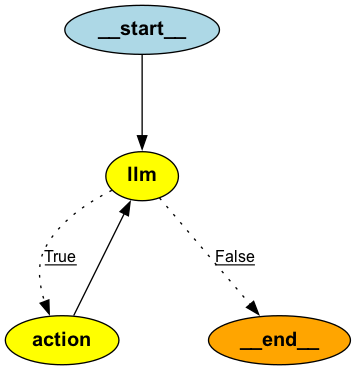

In [155]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [156]:
messages = [HumanMessage(content="What is the weather in sf?")]
messages = abot.graph.invoke({"messages": messages})
print(messages)
messages['messages'][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_qjJ2uhbC4iHO5ux3svr2Dp7I', 'type': 'tool_call'}
Back to the model!
{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qjJ2uhbC4iHO5ux3svr2Dp7I', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 291, 'total_tokens': 312, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bfeaabbe-8dc0-441e-99a9-5546aad05899-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'qu

'The current weather in San Francisco is sunny with a temperature of 66.7°F. Here is what Marcus Aurelius had to say on this matter: "You have power over your mind - not outside events. Realize this, and you will find strength."'

In [157]:
messages = [HumanMessage(content="Shitty life")]
messages = abot.graph.invoke({"messages": messages})
print(messages)
messages['messages'][-1].content

Calling: {'name': 'stoic_collection_search', 'args': {}, 'id': 'call_nLT72XHvbBbjBd0K81dIGy4d', 'type': 'tool_call'}

 ....bad tool name....
Back to the model!
{'messages': [HumanMessage(content='Shitty life', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nLT72XHvbBbjBd0K81dIGy4d', 'function': {'arguments': '{}', 'name': 'stoic_collection_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 287, 'total_tokens': 298, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2fc05806-5c65-4481-8ed9-c639e9dbea09-0', tool_calls=[{'name': 'stoic_collection_search', 'args': {}, 'id': 'call_nLT72XHvbBbjBd0K81dIGy4d', 'type': 'tool_call'}], usage_m

'Here is what Marcus Aurelius had to say on this matter: "You have power over your mind - not outside events. Realize this, and you will find strength."'

In [158]:
messages = [HumanMessage(content="I want to learn good morals and the government of my temper")]
messages = abot.graph.invoke({"messages": messages})
print(messages)
messages['messages'][-1].content


{'messages': [HumanMessage(content='I want to learn good morals and the government of my temper', additional_kwargs={}, response_metadata={}), AIMessage(content='Here is what Marcus Aurelius had to say on this matter:\n"The best revenge is to be unlike him who performed the injury."', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 296, 'total_tokens': 323, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6bb15041-3a83-43b2-bf4c-3ffa5f51c591-0', usage_metadata={'input_tokens': 296, 'output_tokens': 27, 'total_tokens': 323, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}


'Here is what Marcus Aurelius had to say on this matter:\n"The best revenge is to be unlike him who performed the injury."'

In [159]:
messages = [HumanMessage(content="Who is Aomine Daiki?")]
messages = abot.graph.invoke({"messages": messages})
print(messages)
messages['messages'][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Aomine Daiki'}, 'id': 'call_EYFxF8BE0OXQRCwCx7TFdxtv', 'type': 'tool_call'}
Calling: {'name': 'stoic_collection_search', 'args': {'query': 'emotions'}, 'id': 'call_qBdaShM0MoIZCjQAU5pXfije', 'type': 'tool_call'}

 ....bad tool name....
Back to the model!
{'messages': [HumanMessage(content='Who is Aomine Daiki?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EYFxF8BE0OXQRCwCx7TFdxtv', 'function': {'arguments': '{"query": "Aomine Daiki"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_qBdaShM0MoIZCjQAU5pXfije', 'function': {'arguments': '{"query": "emotions"}', 'name': 'stoic_collection_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 292, 'total_tokens': 345, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_de

"Aomine Daiki is a blue-haired basketball player and the main protagonist of Kuroko's Basketball. He is a former member of the Generation of Miracles, a group of prodigies who dominated the sport. If you have any questions or need more information about him, feel free to ask!"